# Dependências

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt

# Configurações

In [28]:
SEQUENCE_LENGTH = 200
TOTAL_SAMPLES = 2000
HIDDEN_UNIT_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.01

# Utils

In [29]:
def create_pure_long_dependency_dataset(seq_len, num_samples, noise_level=0.1):
    """
    Cria um dataset de previsão de séries temporais baseado em uma reta aleatória (a*x + b).
    O alvo (y) é o próximo ponto da série (X[T]).
    """
    X = np.zeros((num_samples, seq_len, 1)).astype(np.float32)
    y = np.zeros((num_samples, 1)).astype(np.float32)

    # Vetor de tempo (t = 0, 1, 2, ..., seq_len - 1)
    time_steps = np.arange(seq_len).reshape(-1, 1)

    for i in range(num_samples):
        # Coeficientes aleatórios:
        # a (declive/slope): entre -1.0 e 1.0
        # b (intercepto/bias): entre -2.0 e 2.0
        a = np.random.uniform(-1.0, 1.0)
        b = np.random.uniform(-2.0, 2.0)

        # Gerar a série (X) e o próximo ponto (y)
        trend = a * time_steps + b

        # Adicionar ruído:
        noise = np.random.uniform(-noise_level, noise_level, (seq_len, 1))

        # Sequência de entrada X
        X[i, :, :] = trend + noise

        # Alvo y: O próximo ponto da série, sem ruído para um target mais limpo
        y[i, 0] = a * seq_len + b

    # Normalização: Importante para Regressão RNN
    # Normalizamos X e y para o intervalo [0, 1] ou [-1, 1]
    # Usaremos uma normalização simples baseada em estimativas do range
    max_val = np.max(np.abs(X)) * 1.5 # buffer
    X /= max_val
    y /= max_val

    return X, y

# Dataset

In [30]:
X_train, y_train = create_pure_long_dependency_dataset(SEQUENCE_LENGTH, TOTAL_SAMPLES)
X_val, y_val = create_pure_long_dependency_dataset(SEQUENCE_LENGTH, TOTAL_SAMPLES // 5)

print(f"Shape de Treinamento X: {X_train.shape}")
print(f"Shape de Treinamento y: {y_train.shape}")

Shape de Treinamento X: (2000, 200, 1)
Shape de Treinamento y: (2000, 1)


# Arquitetura

In [31]:
# Modelo SimpleRNN ---
rnn_model = Sequential([
    SimpleRNN(HIDDEN_UNIT_SIZE, input_shape=(SEQUENCE_LENGTH, 1)),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer=SGD(learning_rate=LEARNING_RATE),
                  loss='mse')

print("\nModelo SimpleRNN Sumário:")
rnn_model.summary()


Modelo SimpleRNN Sumário:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 0 (0.00 B)

# Treinamento

In [32]:
# Treinamento ---

print("\n--- Treinando SimpleRNN ---")
rnn_history = rnn_model.fit(X_train, y_train, epochs=EPOCHS,
                            validation_data=(X_val, y_val))


--- Treinando SimpleRNN ---
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.1704 - val_loss: 0.0971
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0958 - val_loss: 0.0863
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0828 - val_loss: 0.0824
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0819 - val_loss: 0.0808
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0765 - val_loss: 0.0814
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0800 - val_loss: 0.0792
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0756 - val_loss: 0.0791
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0780 - val_loss: 0.0785
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0750 - val_loss: 0.0783
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0745 - val_loss: 0.0780
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0759 - val_loss: 0.0778
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━

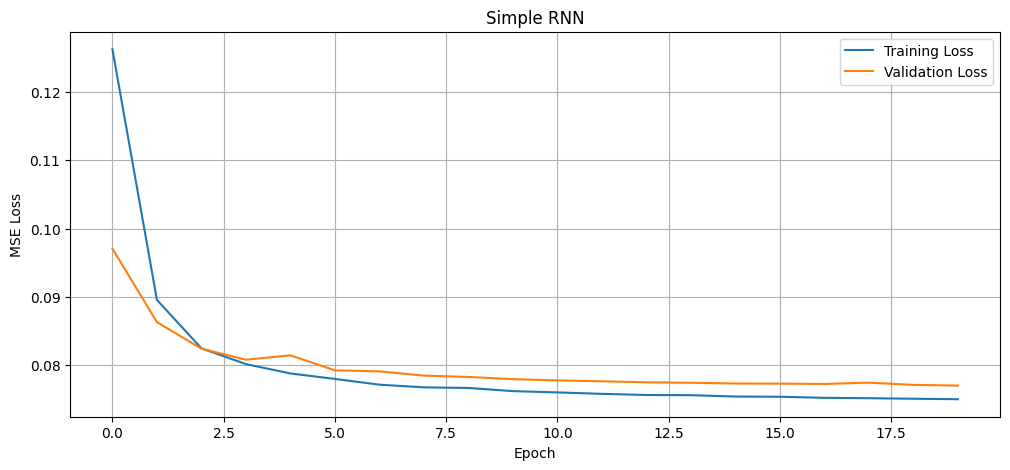

In [34]:
# Plotting para visualização
plt.figure(figsize=(12, 5))

# Plot Loss
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.show()